# Advanced Lane Finding

In this Jupyter notebook we are going to implement the different steps to detect the road lanes with the techniques learnt in the lessons of the Udacity web

### Camera Calibration

In this first cell we are going to read all the calibration files, caclulate the chessboard corners and link them to the 2D coordiantes of the grid

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In the next cell we calibrate the camera with the points obtained in the last cell and undistort one of the sample images 

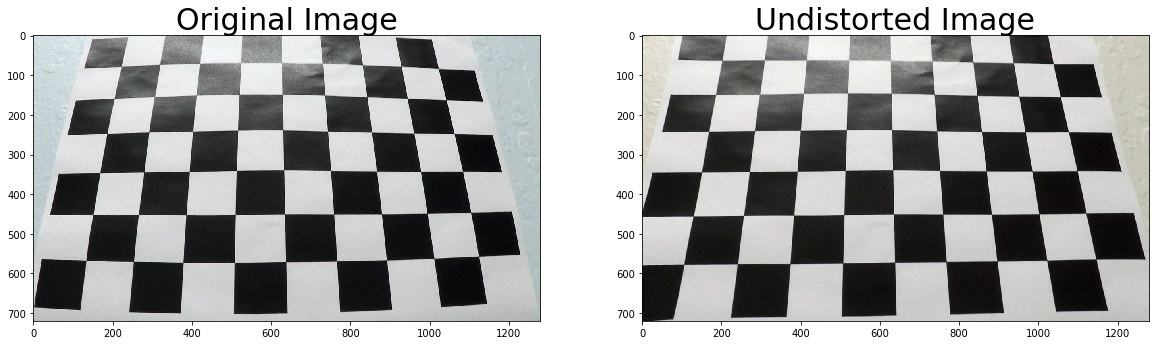

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration3_un.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
#plt.imshow(dst)

Now we are going to undistort the sample images of the road and save them in the output_images directory

output_images/test_images/straight_lines1.jpg
output_images/test_images/straight_lines2.jpg


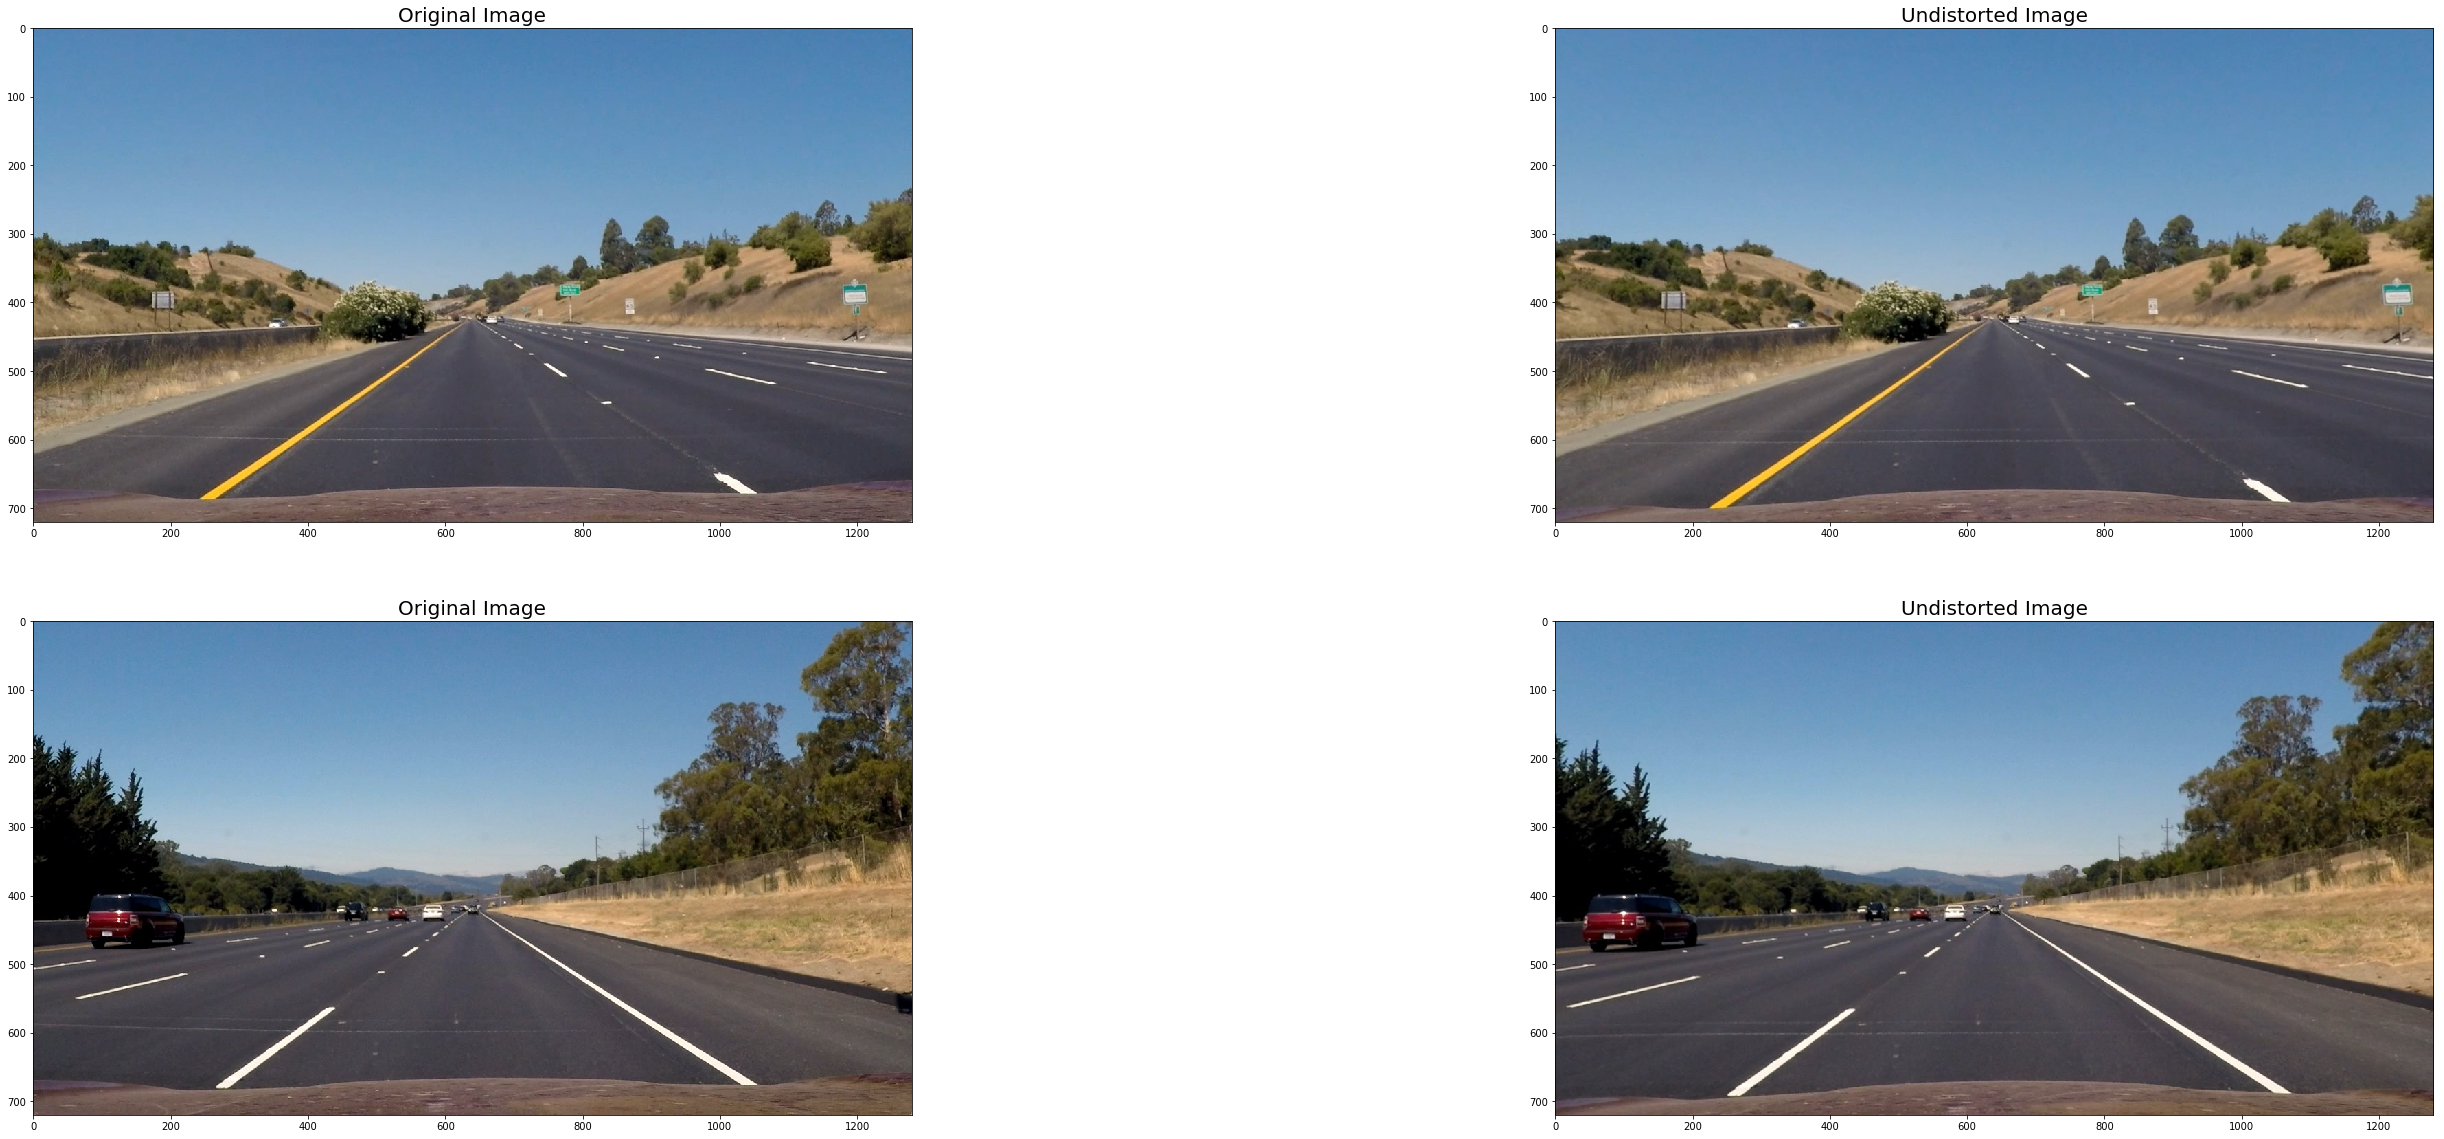

In [3]:
images = glob.glob('test_images/str*.jpg')
dist_pickle = pickle.load(open("wide_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
f, axarr = plt.subplots(len(images), 2, figsize=(50,20))
cont=0
for idx, fname in enumerate(images):
    if "\\" in fname:
        fname=fname.replace("\\","/")
    arr=fname.split("/")
    if (len(arr)>=1):
        lastname=arr[len(arr)-1]
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    axarr[cont,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axarr[cont,0].set_title('Original Image', fontsize=20)
    axarr[cont,1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    axarr[cont,1].set_title('Undistorted Image', fontsize=20)
    print("output_images/"+fname)
    cv2.imwrite("output_images/"+lastname,dst)
    cont+=1

Next we are going to do a perspective transform

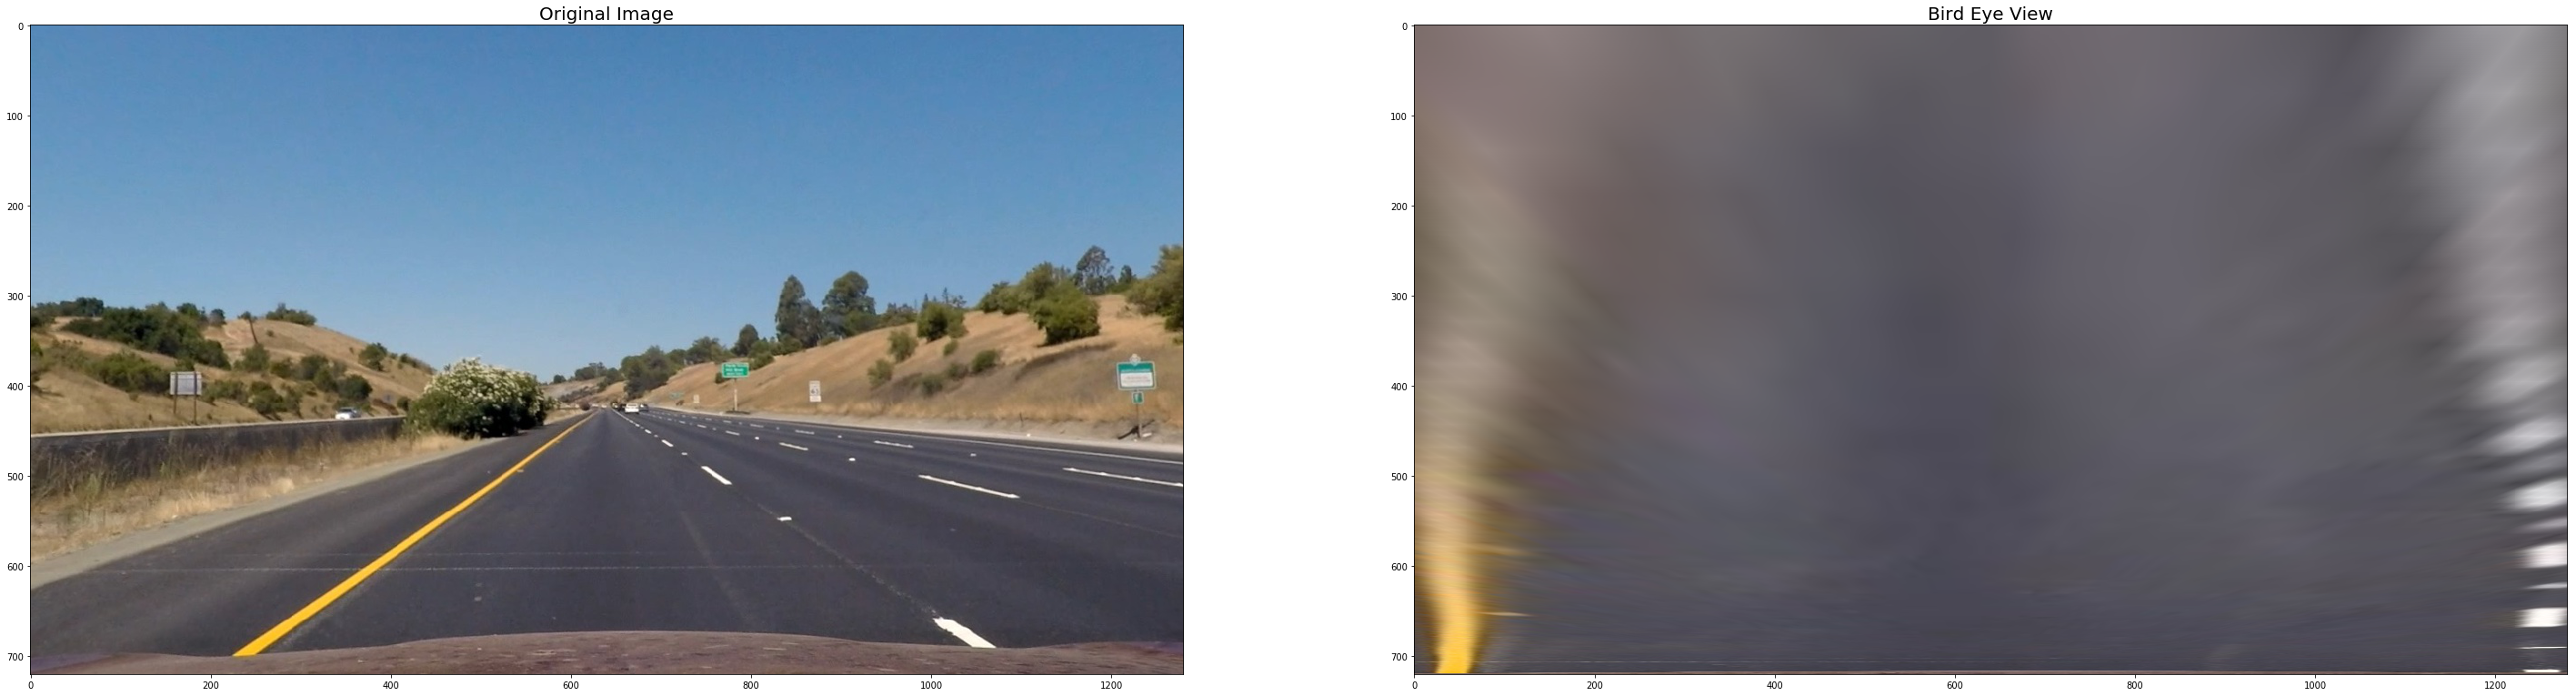

In [7]:
def calc_warp_points(img_height,img_width,x_center_adj=0):
    
    # calculator the vertices of the region of interest
    imshape = (img_height, img_width)
    xcenter=imshape[1]/2+x_center_adj
    xfd=54
    yf=450
    xoffset=120
    
    src = np.float32(
        [(xoffset,imshape[0]),
         (xcenter-xfd, yf), 
         (xcenter+xfd,yf), 
         (imshape[1]-xoffset,imshape[0])])
    
    
    dst = np.float32(
        [(xoffset,imshape[1]),
         (xoffset,0),
         (imshape[0]-xoffset, 0),
        (imshape[0]-xoffset,imshape[1])])
        
    return src, dst

def calc_perspective(img, source_points, target_points):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(source_points, target_points)
    return M
def perspective_transofrm(img, M):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size)
img = cv2.imread('output_images/straight_lines1.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#source_points,target_points=calc_warp_points(img.shape[0],img.shape[1])
src=np.float32([[625,430],[653,430],[1105,720],[204,720]])
dst_points=np.float32([[300,0],[980,0],[980,720],[300,720]])
#src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
#dst = np.float32([[0, 0], [1280, 0],[1250, 720],[40, 720]])
M=calc_perspective(img,src,dst)
birdimg=perspective_transofrm(img,M)
f, axarr = plt.subplots(1, 2, figsize=(50,20))
axarr[0].imshow(img)
axarr[0].set_title('Original Image', fontsize=20)
axarr[1].imshow(birdimg)
axarr[1].set_title('Bird Eye View', fontsize=20)

Now we are going to detect the edges from the road

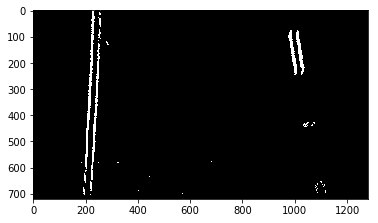

In [70]:
# The img must be in the BGR color space
def abs_sobel_thresh(img, orient='x', thresh=(30, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if (orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary
def mag_thresh(img, sobel_kernel=3, thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output
def dir_thresh(image, sobel_kernel=3, thresh=(0.9, 1.0)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output
plt.imshow(abs_sobel_thresh(birdimg),cmap='gray')

I´m going to create some methods to extract gradient colors

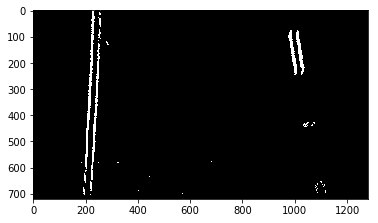

In [71]:
def extract_hlschannel(img, thresh=(90, 255),channel=2):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    C = hls[:,:,channel]
    binary = np.zeros_like(C)
    binary[(C >= thresh[0]) & (C <= thresh[1])] = 1
    return binary
def extract_rgbchannel(img, thresh=(200, 255),channel=0):
    C = img[:,:,channel]
    binary = np.zeros_like(C)
    binary[(C > thresh[0]) & (C <= thresh[1])] = 1
    return binary
def pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    sxbinary=abs_sobel_thresh(img)
    # Threshold color channel
    s_binary=extract_hlschannel(img,thresh=s_thresh)
    #s_binary = np.zeros_like(s_channel)
    #s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    binary = np.zeros_like(sxbinary)
    binary[(sxbinary == 1)] = 1
    return binary
hls=extract_hlschannel(birdimg)
abs_grad=abs_sobel_thresh(img)
binary=pipeline(birdimg)
plt.imshow(binary,cmap='gray')

Let´s calculate the histogram along all the columnsin the lower half of the image

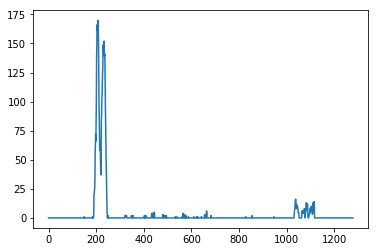

In [72]:
histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [73]:
binary_warped=binary
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 56
# Set minimum number of pixels found to recenter window
minpix = 40
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

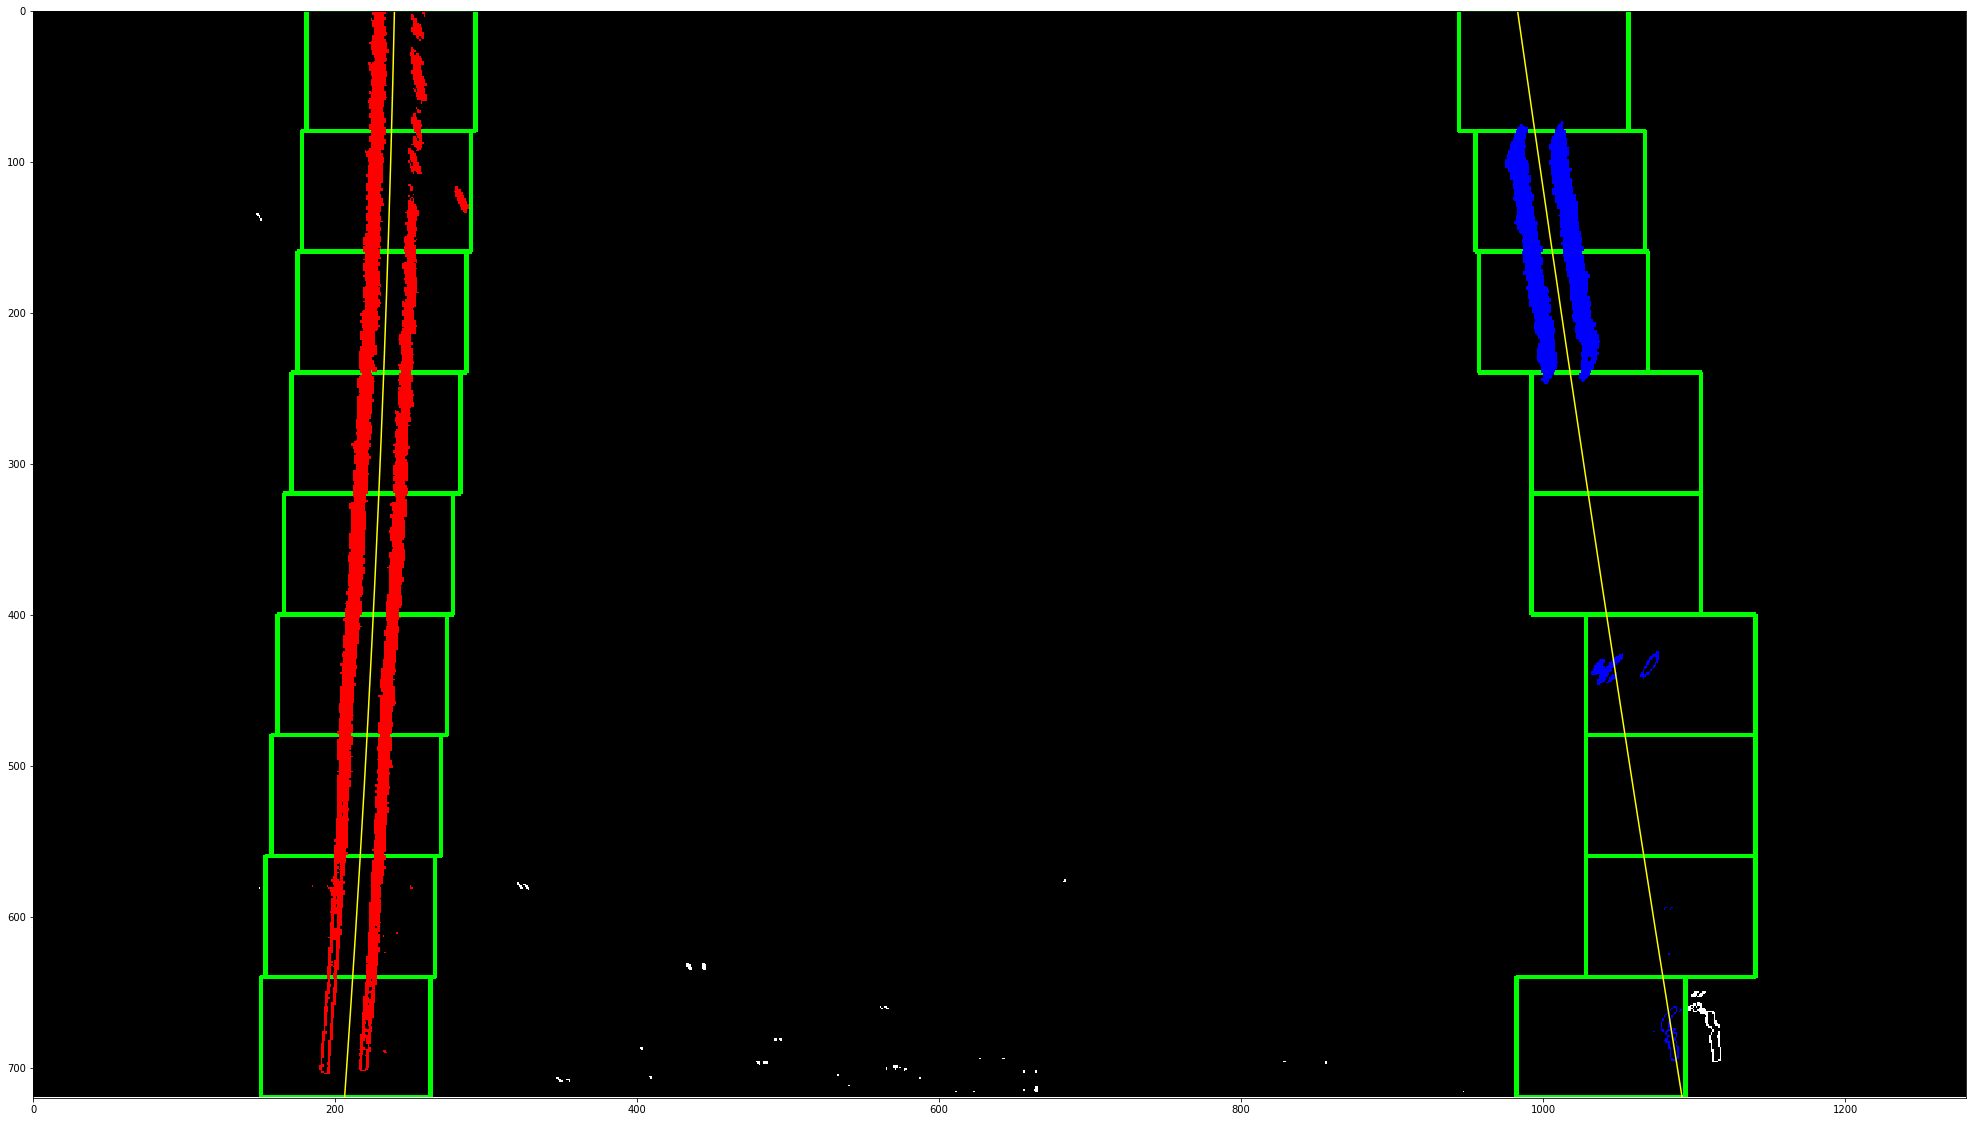

In [74]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
f, axarr = plt.subplots(1, 1, figsize=(50,20))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [51]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 56
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

y_eval = 720
ym_per_pix = 3/273 # meters per pixel in y dimension
xm_per_pix = 3.7/410 # meters per pixel in x dimension

left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
print(left_fit_cr)
print(right_fit_cr)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

[ 0.00600334 -0.15425554  2.33626417]
[ 0.0075004  -0.18207934  6.52071089]
83.3137770517 m 66.7467429759 m


(1280, 0)

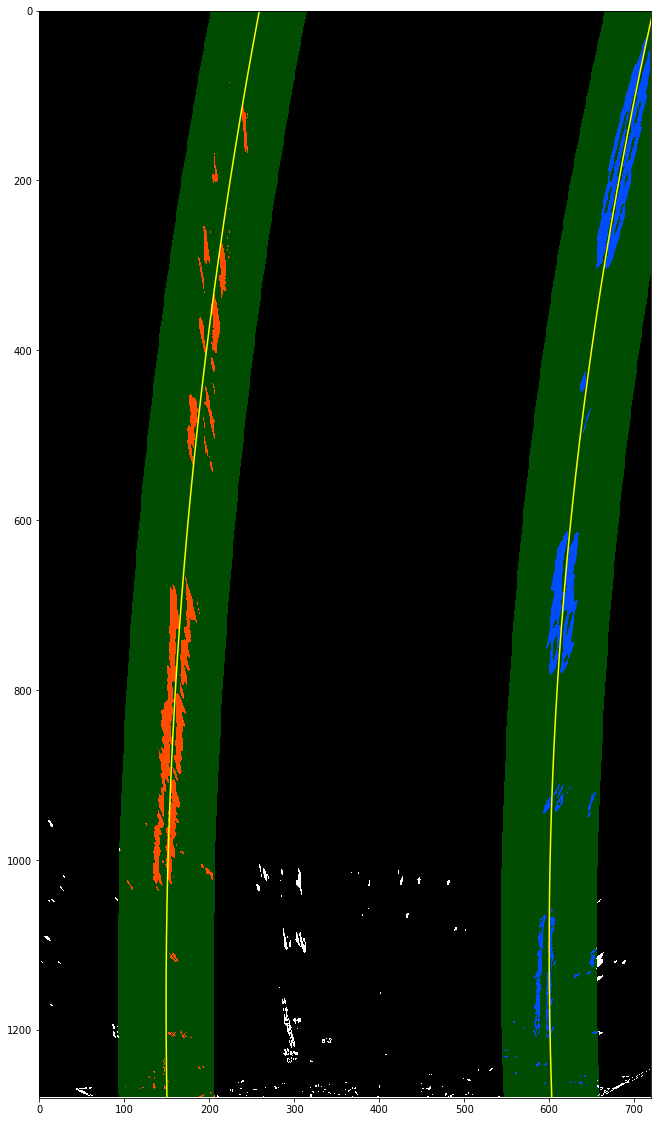

In [52]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
f, axarr = plt.subplots(1, 1, figsize=(50,20))
plt.imshow(result)
cv2.imwrite('output_images/road.jpg',result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 720)
plt.ylim(1280, 0)

In [53]:
y_eval = 1280
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

6227.08466731 4991.06843035


In [54]:


print(len(ploty))
print(len(leftx))
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1280
8264


TypeError: expected x and y to have same length